In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from collections import Counter

In [3]:
data_dir = './experiments-results/'
filenames = os.listdir(data_dir)
filenames[:] = [x for x in filenames if x != '.DS_Store'] # remove '.DS_Store' if it exists"

In [4]:
results = {}
for fn in filenames:
    with open(f'{data_dir}/{fn}', 'r') as jsonfile:
        results[fn] = json.load(jsonfile)

In [5]:
d = {
    'seed': [],
    'p': [],
    'q': [],
    'ts': [],
    'e2e_ebits': [],
    # 'x_dist': [],
    # 'y_dist': [],
}

for k in results.keys():
    seed = results[k]['params_used']['seed']
    p = results[k]['params_used']['qc_p_loss_init']
    q = results[k]['params_used']['prob_swap_loss']

    tslots = list(Counter(results[k]['results']['time_slot']).keys())        # gives timeslots in which there was >=1 e2e ebit
    e2e_per_ts = list(Counter(results[k]['results']['time_slot']).values())    # gives the num of e2e_ebits for each of the ts (same order as above)
    for idx, t in enumerate(tslots):
        d['seed'].append(seed)
        d['p'].append(p)
        d['q'].append(q)
        d['ts'].append(t)
        d['e2e_ebits'].append(e2e_per_ts[idx])
        # d['x_dist'].append(results[k]['results']['x_dist'])
        # d['y_dist'].append(results[k]['results']['y_dist'])

df = pd.DataFrame(data=d)

<Axes: xlabel='p'>

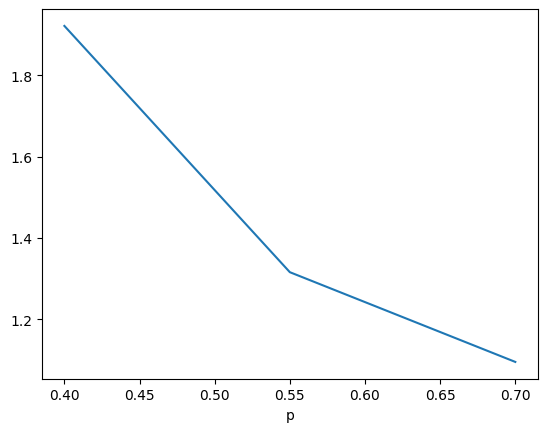

In [6]:
df
df.groupby('p').e2e_ebits.mean().plot()
# df.groupby('q').e2e_ebits.mean().plot()

In [7]:
d = {
    'seed': [],
    'p': [],
    'q': [],
    # 'ts': [],
    'e2e_ebits': [],
    'x_dist': [],
    # 'y_dist': [],
}

for k in results.keys():
    seed = results[k]['params_used']['seed']
    p = results[k]['params_used']['qc_p_loss_init']
    q = results[k]['params_used']['prob_swap_loss']

    # all_ts = results[k]['results']['time_slot']
    # ts_x_y = []
    # for idx, ts in enumerate(all_ts):
    #     ts_x_y.append((ts, results[k]['results']['x_dist'][idx], results[k]['results']['y_dist'][idx]))

    x_dist_unique = list(Counter(results[k]['results']['x_dist']).keys())
    e2e_per_unique_xdist = list(Counter(results[k]['results']['x_dist']).values())
    for idx, x in enumerate(x_dist_unique):
        d['seed'].append(seed)
        d['p'].append(p)
        d['q'].append(q)
        d['x_dist'].append(x)
        d['e2e_ebits'].append(e2e_per_unique_xdist[idx])

    # y_dist_unique = list(Counter(results[k]['results']['y_dist']).keys())
    # e2e_per_unique_ydist = list(Counter(results[k]['results']['y_dist']).values())
    # for idx, y in enumerate(y_dist_unique):
    #     d['seed'].append(seed)
    #     d['p'].append(p)
    #     d['q'].append(q)
    #     d['y_dist'].append(y)
    #     d['e2e_ebits'].append(e2e_per_unique_ydist[idx])

df = pd.DataFrame(data=d)

<Axes: xlabel='x_dist'>

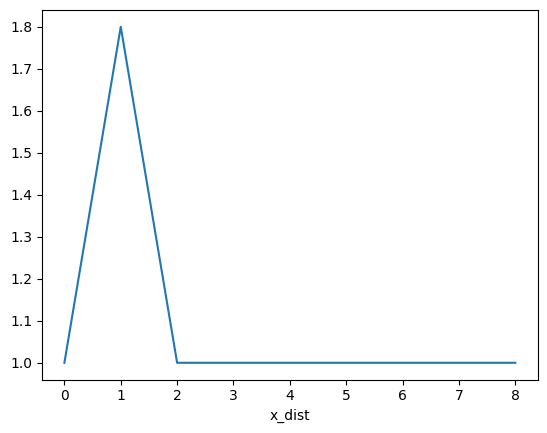

In [8]:
# df
df.loc[(df['p'] == 0.55) & (df['q'] == 0.1)].groupby('x_dist').e2e_ebits.mean().plot()

<Axes: xlabel='x_dist'>

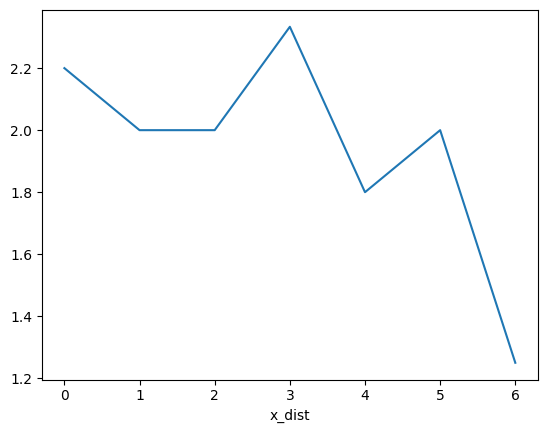

In [9]:
df.loc[(df['p'] == 0.55) & (df['q'] == 0)].groupby('x_dist').e2e_ebits.mean().plot()

<Axes: xlabel='x_dist'>

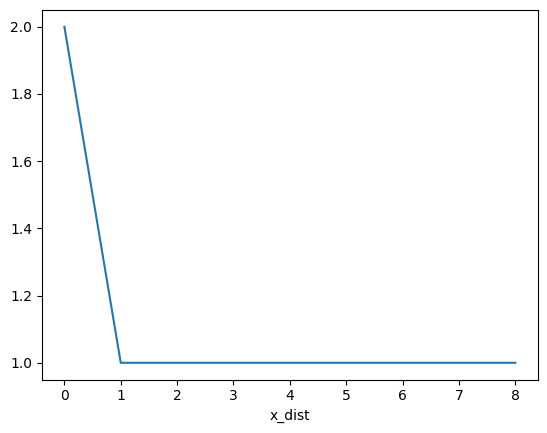

In [10]:
df.loc[(df['p'] == 0.7) & (df['q'] == 0)].groupby('x_dist').e2e_ebits.mean().plot()

<Axes: xlabel='x_dist'>

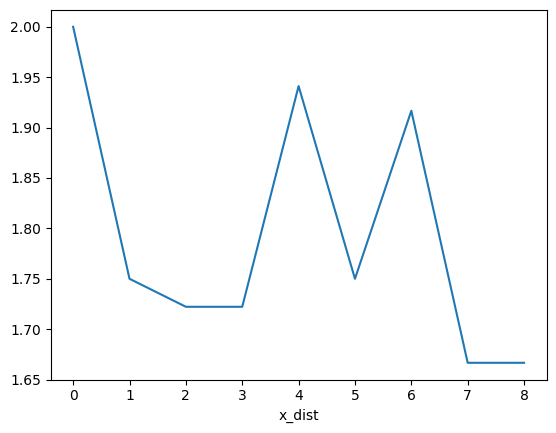

In [11]:
df.groupby('x_dist').e2e_ebits.mean().plot()